In [1]:
import json
import pandas as pd
from collections import Counter, defaultdict
import numpy as np
import tqdm
import os
import re
from matplotlib import pyplot as plt 

In [2]:
dataset_dir = "../Datasets/cei/"

In [3]:
sents = []
dataset = []
number_of_sentences = 0
for file_name in os.listdir(dataset_dir+"/labels"):
    if file_name == '.ipynb_checkpoints':
        continue
    with open(dataset_dir+"/text/"+file_name, "r") as ftext:
        text_sents = ftext.readlines()
        sents.extend(text_sents)
        number_of_sentences += len(text_sents)
        text = " ".join([sent.strip() for sent in text_sents])
    with open(dataset_dir+"/labels/"+file_name, "r") as flabels:
        labels_text = flabels.readline()
        labels_per_sentence = re.split("<", labels_text.strip())[1:]
        labels_per_sentence_cleaned = []
        
        for sent_labels in labels_per_sentence:
            sent_labels_splitted = re.split("AND", sent_labels)
            sent_labels_splitted = [label.split("--")[0].strip().lower() + "--" + label.strip().split("--")[1].lower()
                                    for label in sent_labels_splitted
                                    if label != '' and label != ' ' and "NULL" not in label]
            labels_per_sentence_cleaned.append(sent_labels_splitted)
            
        labels = [label for sent_labels in labels_per_sentence_cleaned for label in sent_labels]
        
#         if len(list(set(labels))) >= 3 and len(list(set(labels))) < 4 and len(text.split(" ")) < 200:
#             print(file_name)
            
        if labels != []:
            dataset.append({'pmid': file_name.strip(".txt"), 
                            'text': text, 
                            'labels': list(set(labels)),
                            'labels_per_sentence': labels_per_sentence_cleaned})

In [4]:
number_of_sentences

36153

In [5]:
print("Number of papers: ", len(dataset))

Number of papers:  3661


# Labels Statistics

In [6]:
labels = [row['labels'] for row in dataset]

In [7]:
print("Average labels per example: ", np.mean([len(label_set) for label_set in labels]))
print("Standard dev labels per example: ", np.std([len(label_set) for label_set in labels]))

Average labels per example:  1.883911499590276
Standard dev labels per example:  0.8587264964259516


In [8]:
frequencies = Counter([c for clist in labels for c in clist])

In [9]:
print("Number of labels:", len(frequencies))
frequencies = dict(sorted(frequencies.items(), key=lambda item: item[1], reverse=True))

Number of labels: 11


In [10]:
frequencies.keys()

dict_keys(['biomonitoring--exposure biomarker', 'exposure routes--oral intake', 'biomonitoring--effect marker', 'exposure routes--inhalation', 'site comparisons--workplace', 'site comparisons--polluted area', 'exposure routes--dermal uptake', 'exposure routes--', 'exposure routes--combined', 'site comparisons--', 'biomonitoring--'])

In [11]:
with open("../Datasets/cei/topics.json", "w") as ftopics:
    for label in frequencies.keys():
        ftopics.write(label + "\n") 

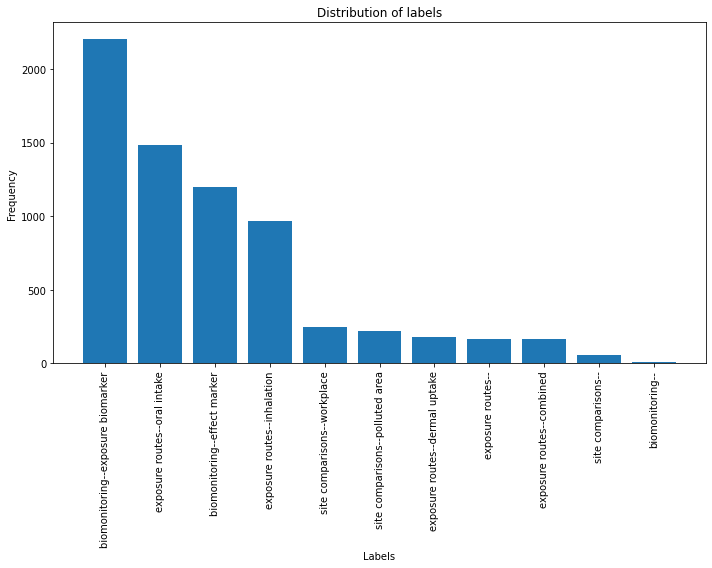

In [12]:
fig = plt.figure(figsize=(10, 8))
plt.bar(x=frequencies.keys(), height=frequencies.values())
plt.title("Distribution of labels")
plt.xlabel("Labels")
plt.xticks(range(len(frequencies)), frequencies.keys(), rotation='vertical')
plt.ylabel("Frequency")
plt.tight_layout()
fig.savefig('cei_label_distribution.png', dpi=600)

# Corpus Statistics

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 3661/3661 [00:00<00:00, 32140.77it/s]


 average words per text: 276.56842392788855
 standard deviation on words per text: 72.86280453406054
 average sentences per text: 9.875170718382956


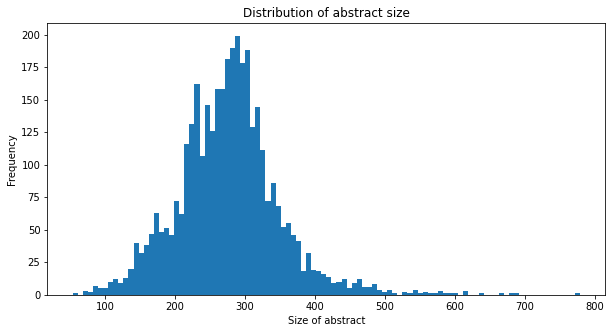

In [13]:
text_words = []
for row in tqdm.tqdm(dataset):
    text = row['text']
    text_words.append(len(text.split()))
    
mean_text_words = np.mean(text_words)
sd_text_words = np.std(text_words)
mean_text_sentences = number_of_sentences / len(dataset)
print(' average words per text:', mean_text_words)
print(' standard deviation on words per text:', sd_text_words)
print(' average sentences per text:', mean_text_sentences)
    
fig = plt.figure(figsize=(10, 5))
plt.title("Distribution of abstract size")
plt.xlabel("Size of abstract")
plt.ylabel("Frequency")
plt.hist(text_words, bins = 100)
fig.savefig('cei_size_distribution.png', dpi=600)

# Save dataset in json format

In [14]:
train_ratio = 0.70
validation_ratio = 0.10
test_ratio = 0.20

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train, test = train_test_split(dataset, test_size=1 - train_ratio, random_state=44)
val, test = train_test_split(test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=44)

In [18]:
len(val)

366

In [19]:
len(train)

2562

In [20]:
len(test)

733

In [21]:
with open("../Datasets/cei/train.json", "w") as ftrain:
    json.dump(train, ftrain)
with open("../Datasets/cei/val.json", "w") as fval:
    json.dump(val, fval)
with open("../Datasets/cei/test.json", "w") as ftest:
    json.dump(test, ftest)